<h1> Spatial Clustering Insights from the 2023 City of Vancouver Property Tax Report </h1>

In [2]:
## Load Relevant Libraries 

# Tidyverse library used for wrangling and tidying data
library(tidyverse)

# Tidymodels library used for kmeans clustering
library(tidymodels)

# Broom used for tidy visualization of clustering
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h1> 1. Data Specification </h1>
This project uses data from the City of Vancouver Open Data Portal 

In [3]:
#setting seed
set.seed(9876)
seed <- 9876

## 2023 CoV Property Tax Report Dataset imported by url (HTTP GET)
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   ZONING_CLASSIFICATION,
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   NEIGHBOURHOOD_CODE,
                   TAX_LEVY)

## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)

# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_parcel_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",") |>
# Convert (lat,long) into numeric data
            mutate(lat = as.double(lat)) |>
            mutate(long = as.double(long))

Rows: 220840 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100164 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [19]:
## Data Tidying
# Filter for housing properties only by zone
property_housing_only <- ptax_parcel_merged |>
    filter(ZONING_CLASSIFICATION == c("Comprehensive Development",
                                      # NOTE: Comprehensive Developments are mixed-use, and could look like an 
                                      # apartment building with shops below, or a shopping mall with a few apartments
                                      # above. This report acknowledges the limitations of this in further sections.
                                      "Single Detached House",
                                      "Multiple Dwelling"))

print(paste("Entry Count before NA and 0 removal: ", nrow(property_housing_only))) 
property_housing_only <- property_housing_only |>
                            filter(CURRENT_LAND_VALUE > 0,
                                   CURRENT_IMPROVEMENT_VALUE > 0,
                                   YEAR_BUILT > 0,
                                   BIG_IMPROVEMENT_YEAR > 0)
print(paste("Entry Count after NA and 0 removal: ", nrow(property_housing_only)))

# Summary table counting each housing type
property_summ_table <- property_housing_only |>
    group_by(ZONING_CLASSIFICATION) |>
    summarize(COUNT = n())
property_summ_table

Warning message in ZONING_CLASSIFICATION == c("Comprehensive Development", "Single Detached House", :
“longer object length is not a multiple of shorter object length”


[1] "Entry Count before NA and 0 removal:  60570"
[1] "Entry Count after NA and 0 removal:  58657"


ZONING_CLASSIFICATION,COUNT
<chr>,<int>
Comprehensive Development,26311
Multiple Dwelling,10310
Single Detached House,22036


`summarise()` has grouped output by 'lat'. You can override using the `.groups`
argument.


[1] "Same-address Property Value Entries: 27124  /  58657  total"


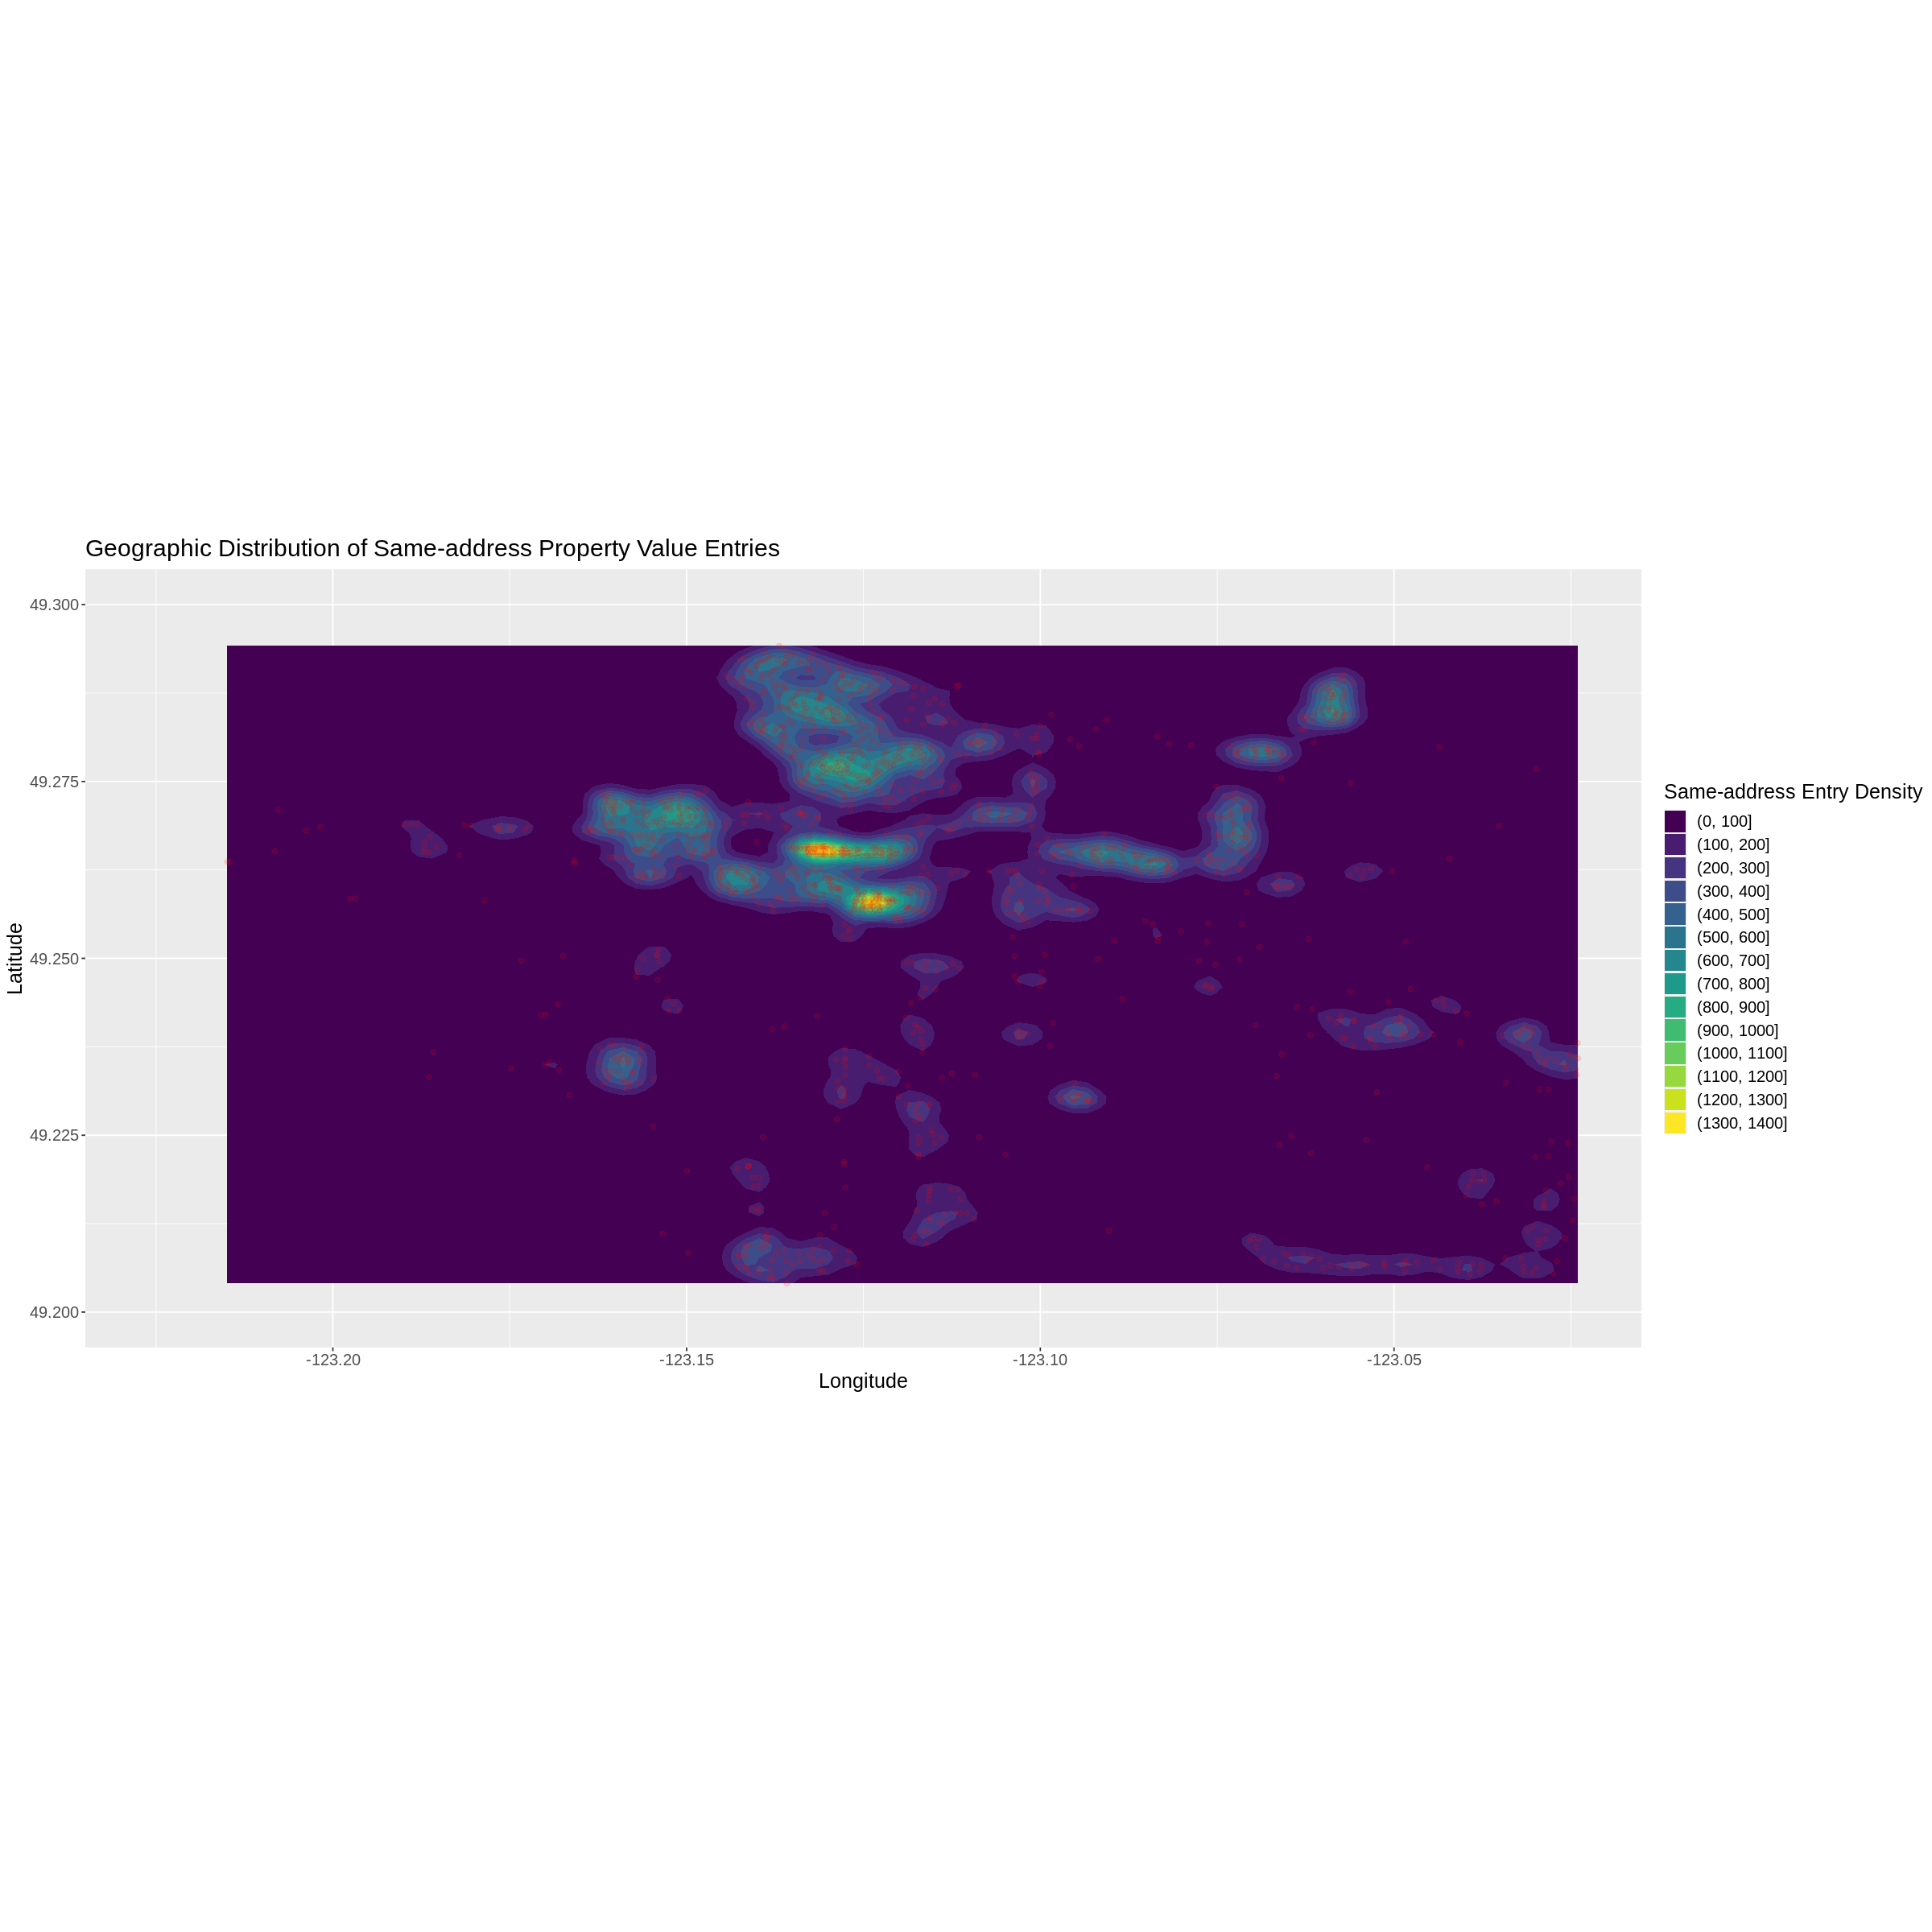

In [28]:
## Address Aggregation
# Find count of same-address property value entries by location

housing_aggregated <- property_housing_only |>
                        group_by(lat, long) |>
                        arrange(long) |>
                        summarize(AGGREGATE_CURRENT_LAND_VALUE = sum(CURRENT_LAND_VALUE),
                                  AGGREGATE_IMPROVEMENT_VALUE = sum(CURRENT_IMPROVEMENT_VALUE),
                                  MEAN_YEAR_BUILT = mean(YEAR_BUILT),
                                  MEAN_BIG_IMPROVEMENT_YEAR = mean(BIG_IMPROVEMENT_YEAR),
                                  MEAN_TAX_LEVY = mean(TAX_LEVY),
                                  SAME_ADDRESS_ENTRIES = n())
# head(housing_aggregated)

print(paste("Same-address Property Value Entries:", nrow(housing_aggregated), " / ", nrow(property_housing_only), " total"))

# Plot Geographic distribution of Same-Address Property Tax Report Entries
options(repr.plot.width = 20, repr.plot.height =20)
property_plot <- housing_aggregated |>
                filter(SAME_ADDRESS_ENTRIES > 1) |>
                ggplot(aes(x=long,y=lat, z= SAME_ADDRESS_ENTRIES)) +
                geom_density_2d_filled(adjust = 1/4) +
                geom_point(alpha = 0.125, color = "red") +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     fill = "Same-address Entry Density", 
                     title = "Geographic Distribution of Same-address Property Value Entries") +
                theme(text = element_text(size = 15))
property_plot

<h1> 2. Calculating Spatial Centroids </h1>

This project will use the spatial centroids of properties within each neighbourhood coded in the Property Tax Report  as an external validation. The first set of centroids consist of those that take into consideration all types of properties within a neighbourhood, and the second set of centroids consist of those that only take the locations of strata housing into consideration.  

<h2> Neighbourhood Centroids using All Properties </h2>

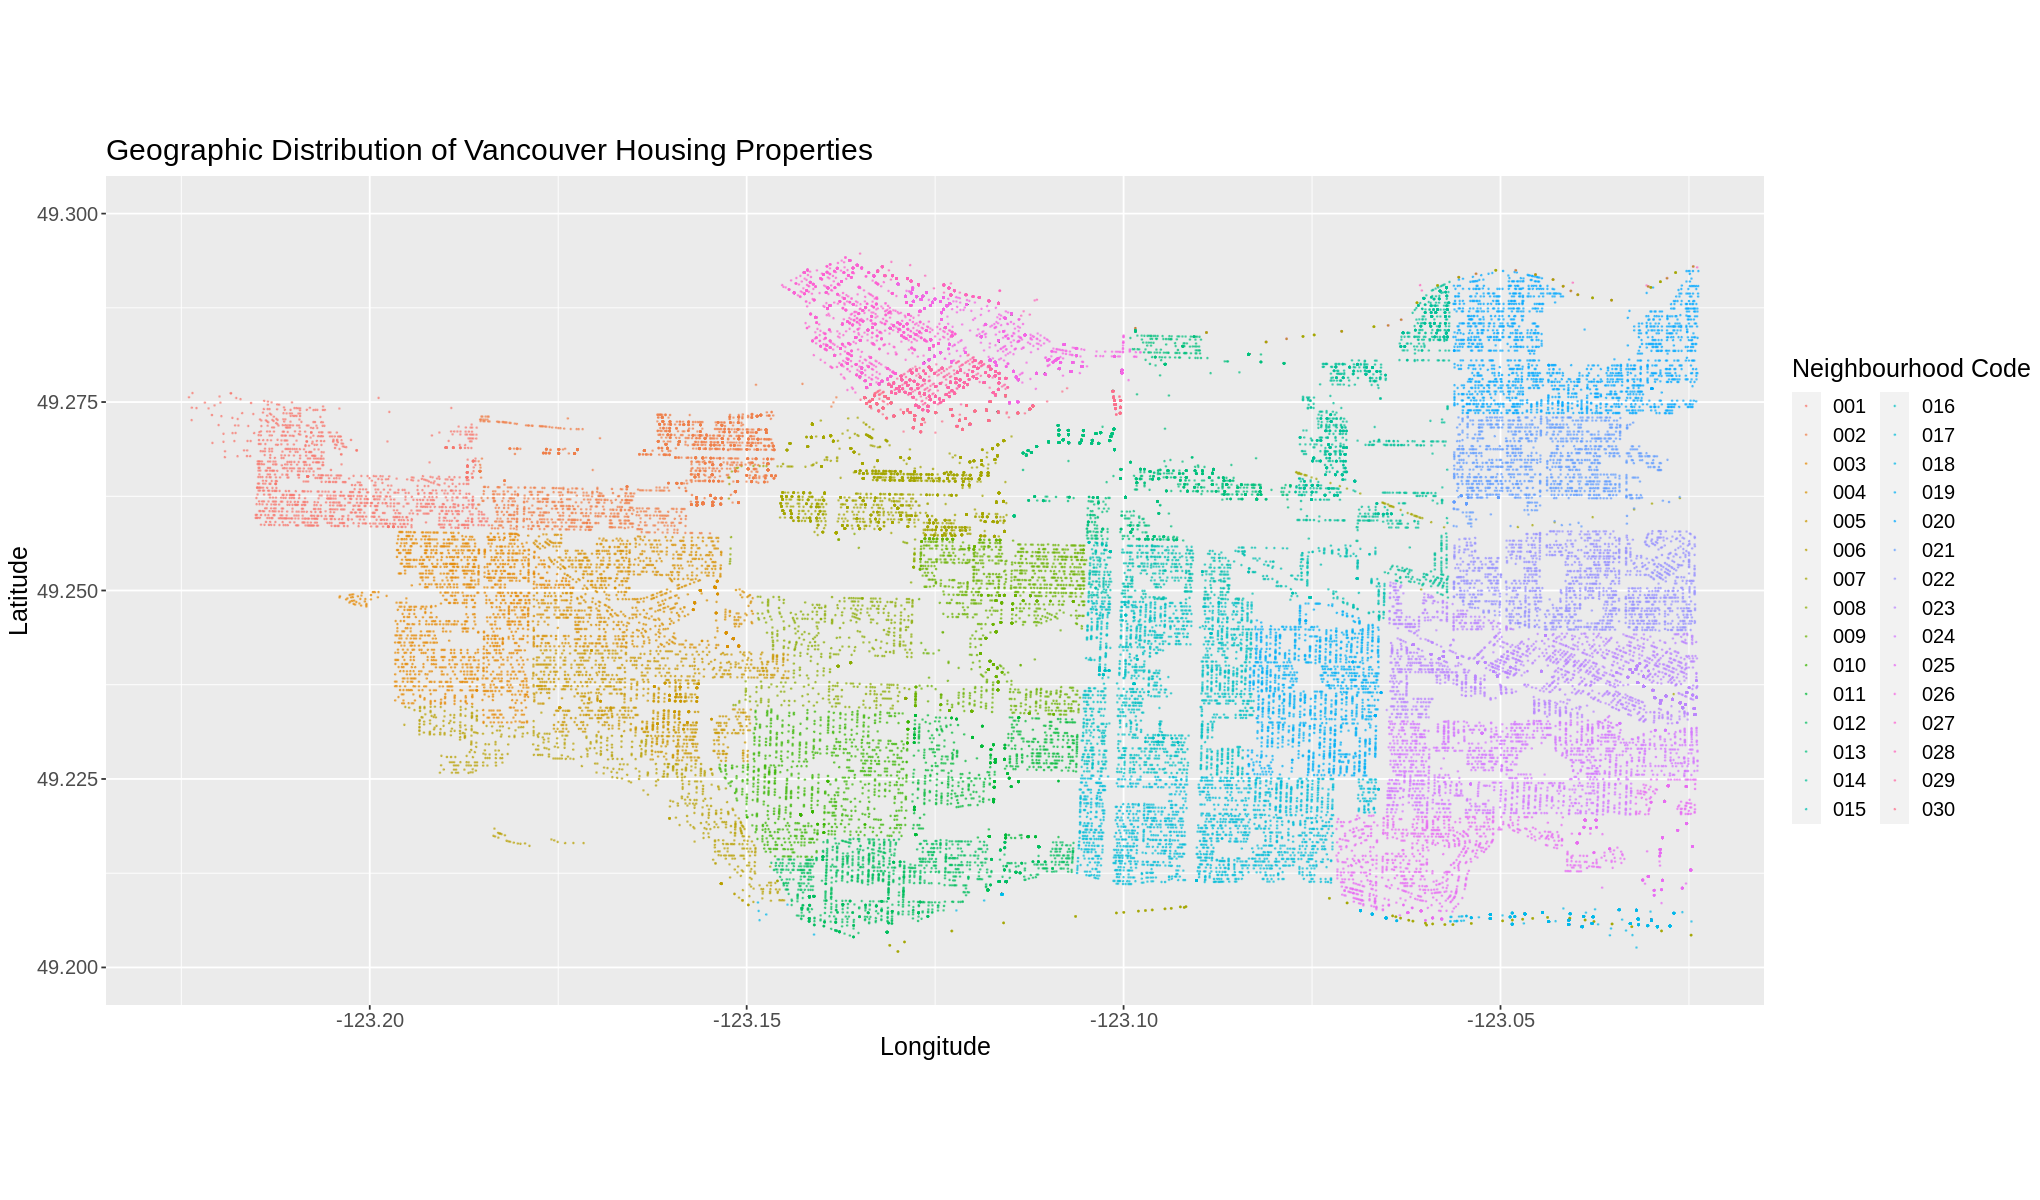

In [9]:
# This plot shows the spatial distribution of all properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
property_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Housing Properties") +
                theme(text = element_text(size = 15))
property_plot

<h2> Neighbourhood Centroids using Strata Properties Only </h2>

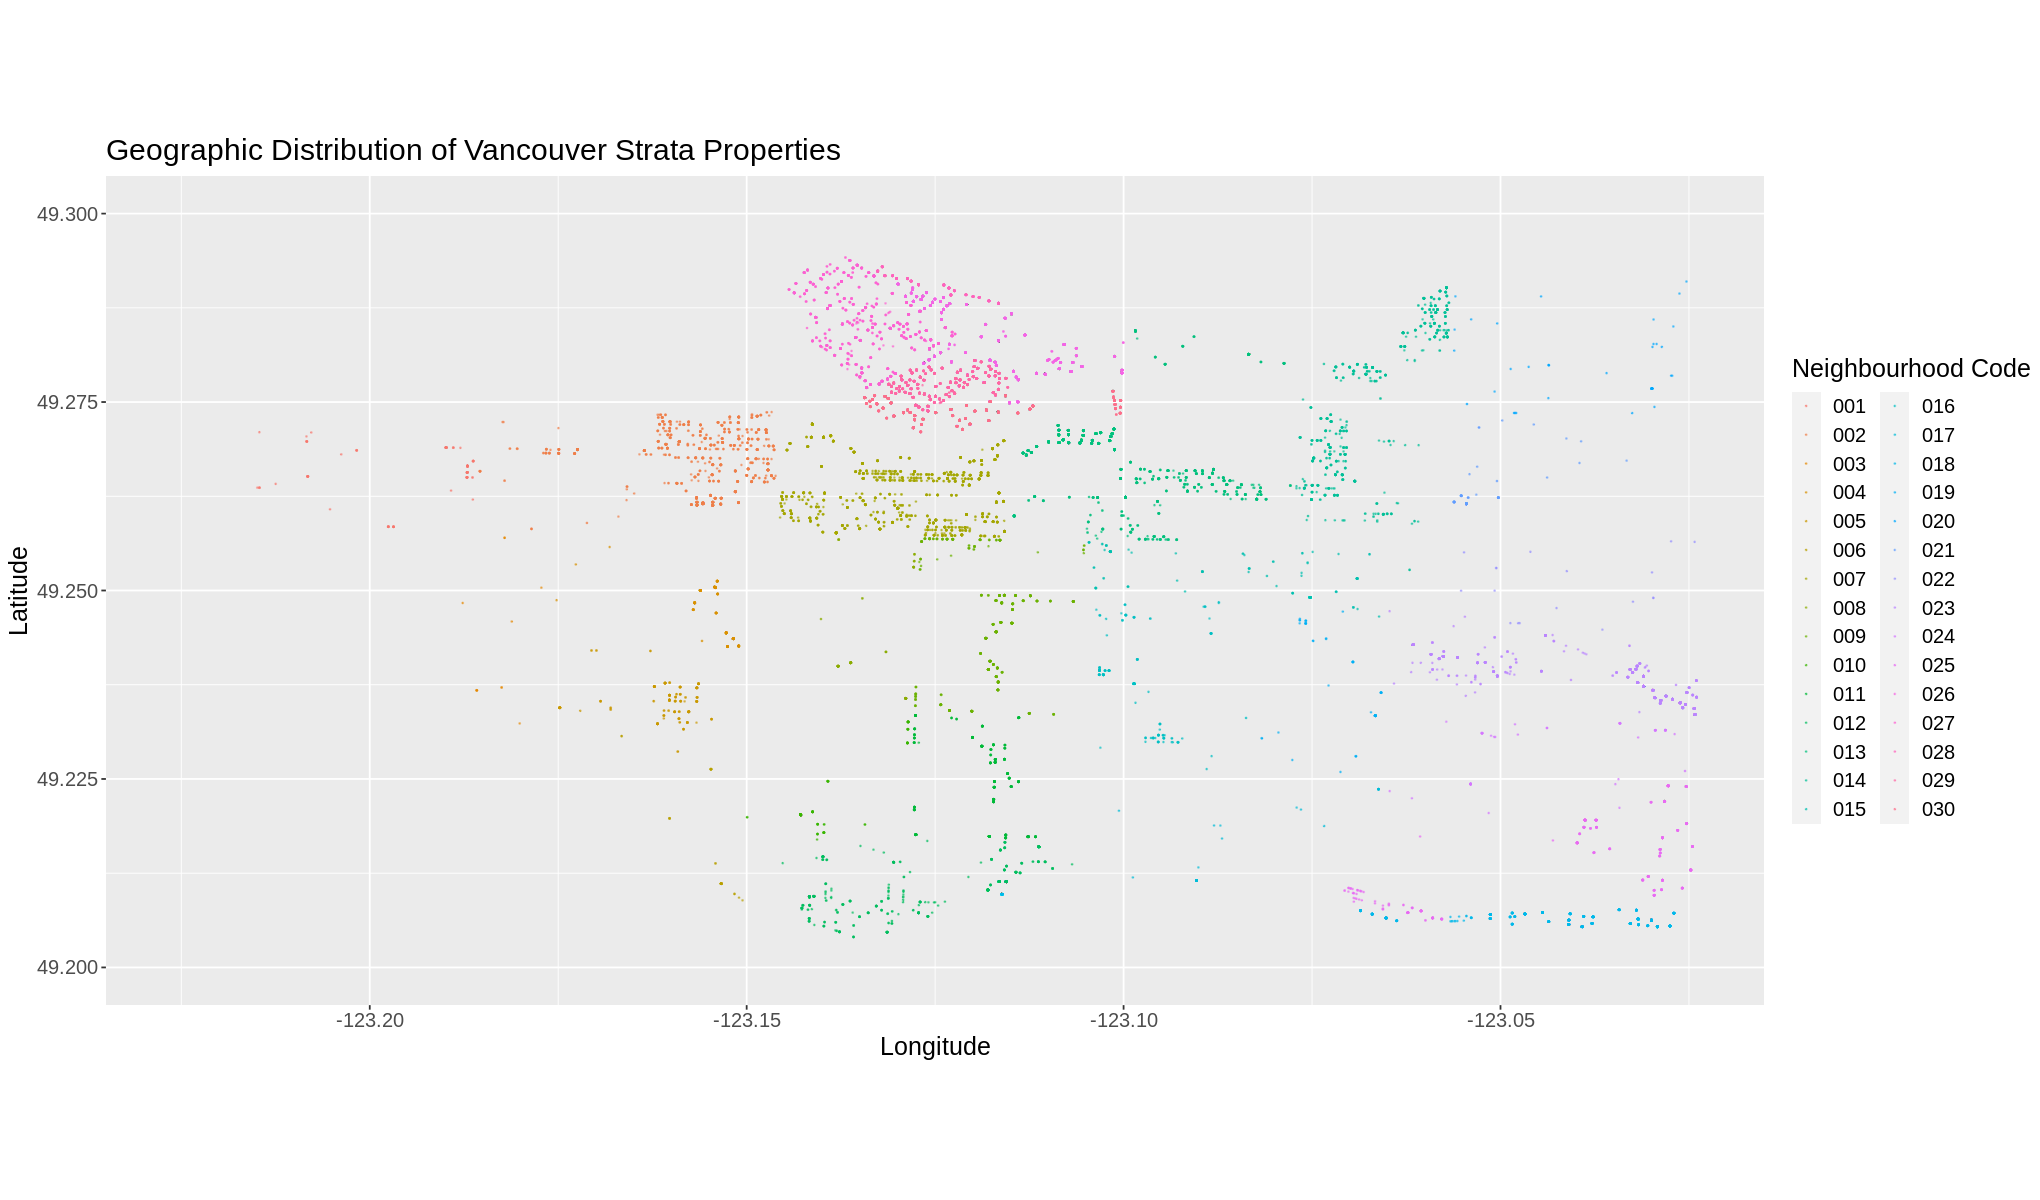

In [12]:
## This plot shows the spatial distribution of strata properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
strata_only_plot <- property_train |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
strata_only_plot

In [71]:
# Strata Housing Centroids
# Group by, summarise, and plot
ptax_centroids <- property_housing_only |>
        group_by(NEIGHBOURHOOD_CODE) |>
        mutate(lat = as.numeric(lat)) |>
        mutate(long = as.numeric(long)) |>
        summarize(centroid_lat = mean(lat),
                  centroid_long = mean(long))

ptax_centroids

NEIGHBOURHOOD_CODE,centroid_lat,centroid_long
<chr>,<dbl>,<dbl>
001,49.26457,-123.2023
002,49.26607,-123.1598
003,49.24704,-123.1871
004,49.24892,-123.1627
005,49.23573,-123.1625
006,49.22399,-123.1677
007,49.26183,-123.1247
008,49.24279,-123.1371
009,49.24663,-123.1163


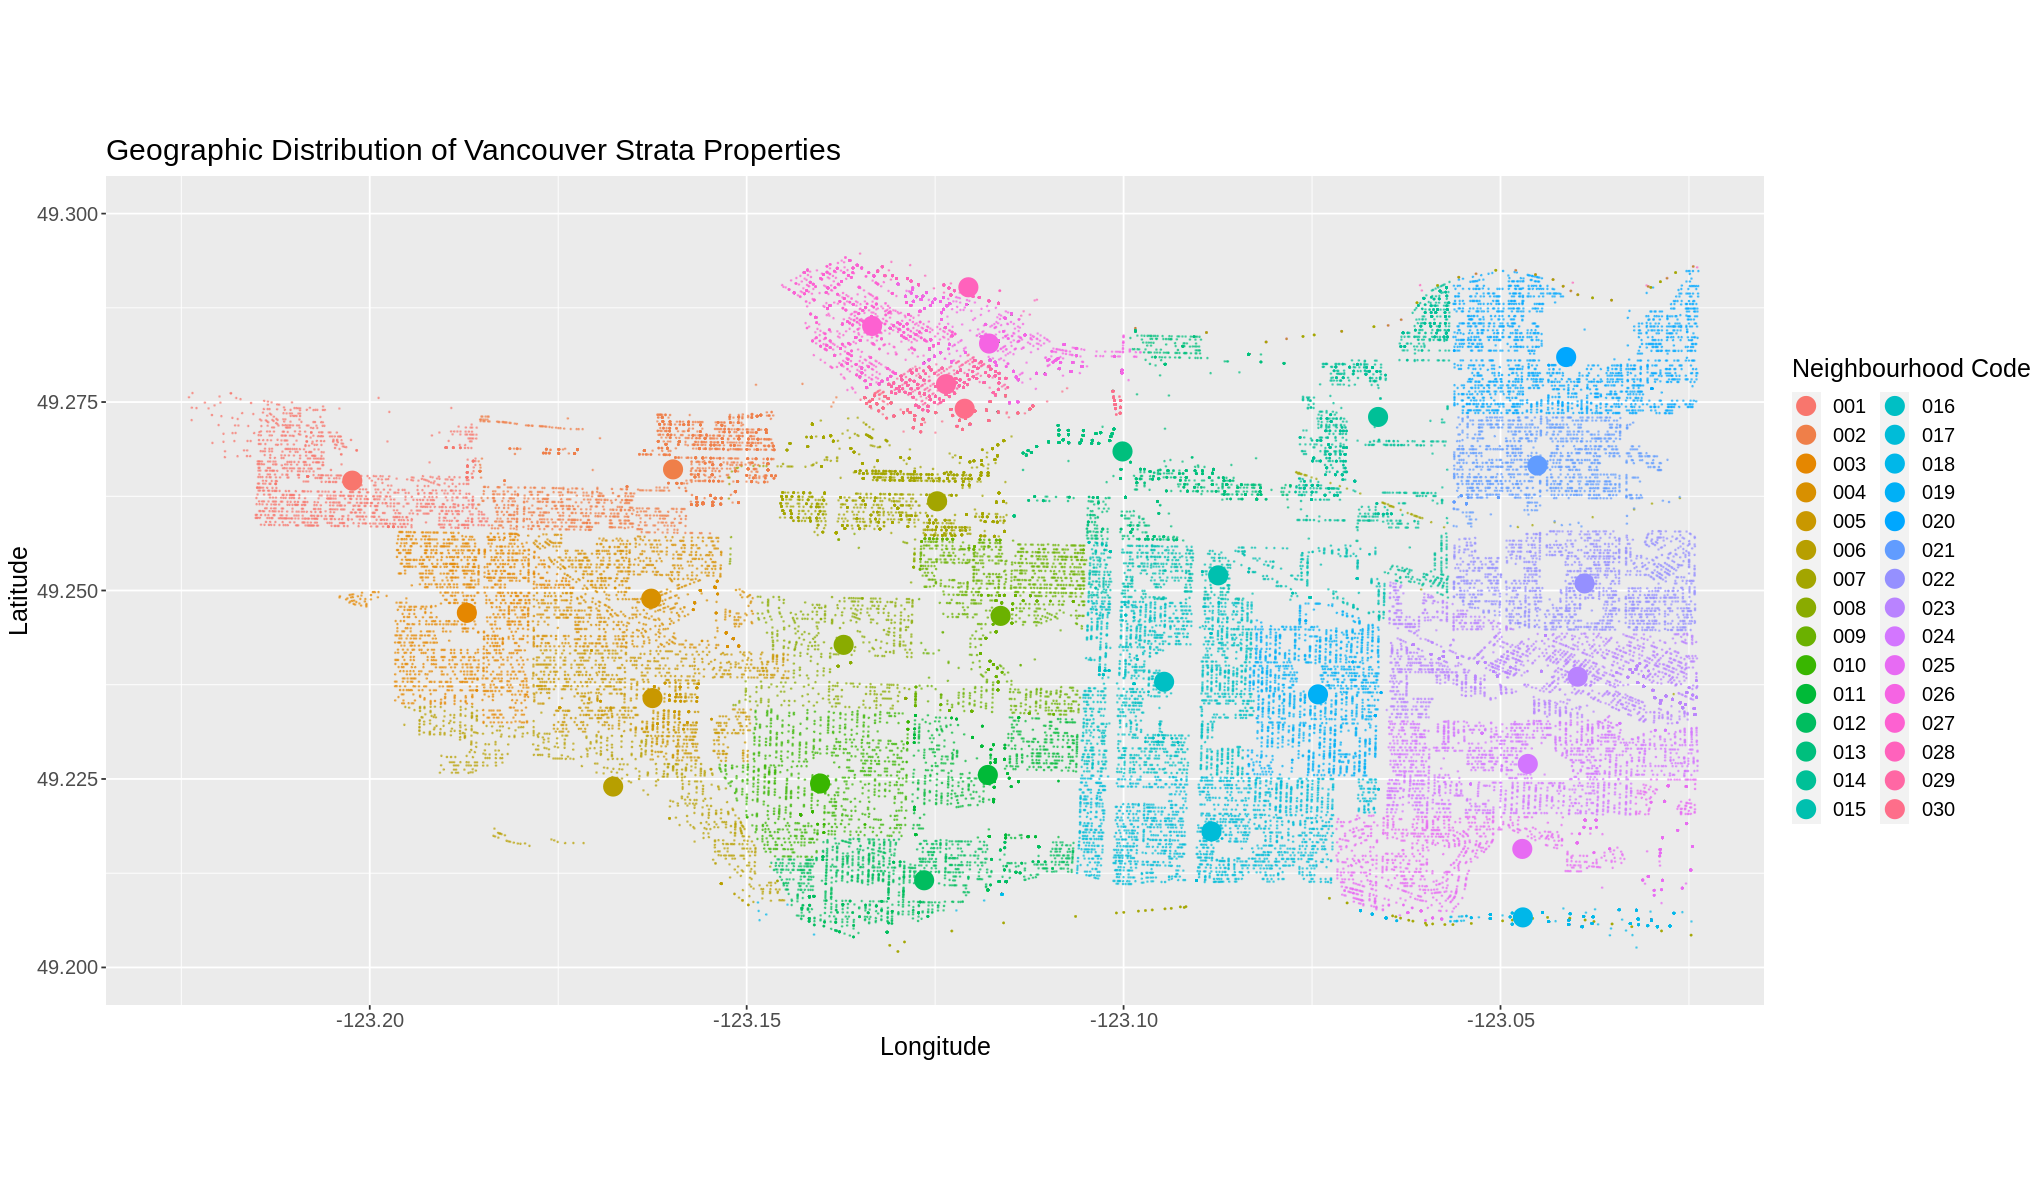

In [72]:

options(repr.plot.width = 17, repr.plot.height =10)
strata_only_centroid_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                geom_point(data = ptax_centroids, aes(x=centroid_long, y=centroid_lat), size = 5) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude",
                     color = "Neighbourhood Code",
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
strata_only_centroid_plot

<h1> 3. Model Parameter Tuning and Feature Selection </h1> 
The model will be tuned a priori using the elbow plot method, and the project will qualitively compare the results using the calculated spatial centroids from Section 3 above.

<h2> </h2>

<h1> 4. Clustering Model </h1>

In [ ]:
# DON'T CHANGE THE SEED VALUE!
set.seed(9876)

<h1> 5. Results Discussion </h1>

<h1> 6. Conclusion </h1>

<h1> 7. References and Resources </h1>